## Getting Started

First let's import all the headers we'll need for this excercise.

In [61]:
import torch
import matplotlib.pyplot as plt

from math import sin, cos, pi

from torch import nn

## Binary Classification

This time we'll do some simply classification problems.

We'll first two binary classification where we want the points to fall into one of two classes.

For example, let's say we have two circles with different radii. We want to classify the points as being part of one of the circles or neither. Let's formulate this problem.

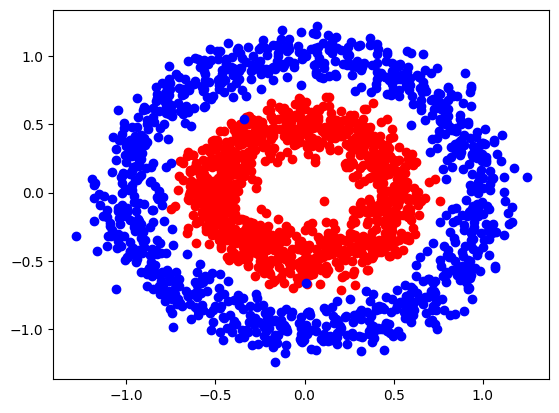

In [67]:
def gen_point(r):
    noise = 0.1
    t = 2 * pi * torch.rand(1)
    x = r * cos(t) + torch.randn(1) * noise
    y = r * sin(t) + torch.randn(1) * noise
    return x, y

num_points = 1000
r1 = 0.5
r2 = 1

circle1 = torch.tensor([gen_point(r1) for _ in range(num_points)])
circle2 = torch.tensor([gen_point(r2) for _ in range(num_points)])

plt.scatter(circle1[:, 0], circle1[:, 1], c='r')
plt.scatter(circle2[:, 0], circle2[:, 1], c='b')
plt.show()


Nice. Now we have two areas we want to classify the points. Let's create the actual training data input from our data points. We have 2000 data points to work with and two classes. A typical split is 70:30 for training and test/validation. Let's do the same.

In [68]:
data = torch.cat([circle1, circle2])
labels = torch.cat([torch.zeros(num_points), torch.ones(num_points)]).float()

# shuffle data
idx = torch.randperm(data.size(0))
data = data[idx]
labels = labels[idx]

# split data
train_data = data[:int(0.7 * data.size(0))]
train_labels = labels[:int(0.7 * data.size(0))]

test_data = data[int(0.7 * data.size(0)):]
test_labels = labels[int(0.7 * data.size(0)):]

print(train_data.size(), train_labels.size())
print(test_data.size(), test_labels.size())

torch.Size([1400, 2]) torch.Size([1400])
torch.Size([600, 2]) torch.Size([600])


Now let's create and train our model.

Epoch 0:
	Loss: 0.7079533934593201
	Accuracy: 0.5166666666666667
Epoch 50:
	Loss: 0.5819048285484314
	Accuracy: 0.7
Epoch 100:
	Loss: 0.3443347215652466
	Accuracy: 0.925
Epoch 150:
	Loss: 0.1721239984035492
	Accuracy: 0.9716666666666667
Epoch 200:
	Loss: 0.10242177546024323
	Accuracy: 0.9766666666666667
Epoch 250:
	Loss: 0.07079565525054932
	Accuracy: 0.98


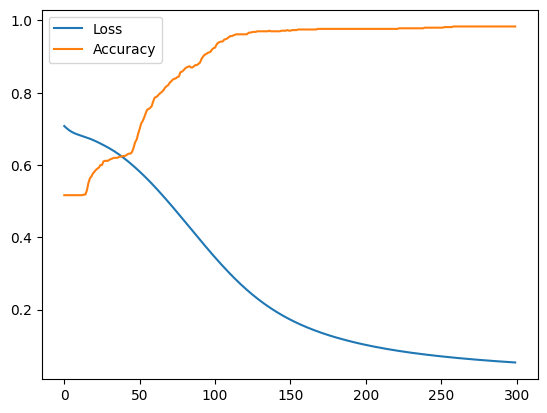

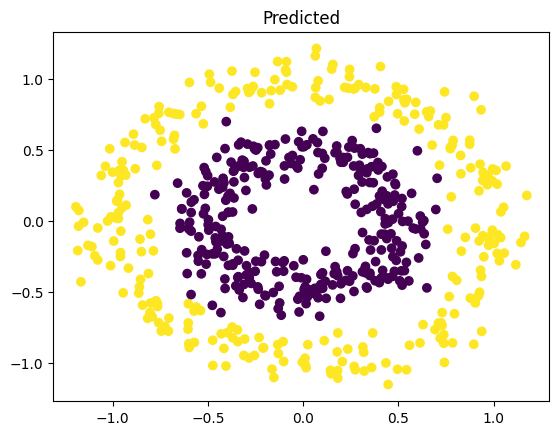

In [69]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            # nn.Sigmoid()  # BCEWithLogitsLoss already applies sigmoid
        )

    def forward(self, x):
        return self.layers(x)


def binary_classification(train_x, train_y, test_x, test_y):
    model = BinaryClassification()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()

    num_epochs = 300

    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x).squeeze()
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f'Epoch {epoch}:\n\tLoss: {loss.item()}')

        with torch.no_grad():
            output = model(test_x).squeeze()
            predicted = (output > 0.5).float()
            accuracy = (predicted == test_y).sum().item() / test_y.size(0)
            accuracies.append(accuracy)
            if epoch % 50 == 0:
                print(f'\tAccuracy: {accuracy}')

    plt.plot(losses)
    plt.plot(accuracies)
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

    plt.scatter(test_data[:, 0], test_data[:, 1], c=predicted)
    plt.title('Predicted')
    plt.show()

binary_classification(train_data, train_labels, test_data, test_labels)


The above model is pretty simple and similar to the MLP we created in the intro.

The model has:
- an input layer that takes in two variables (the `x` and the `y` coordinates)
- one hidden layer with 10 nodes
- an output layer which returns one number

We then run the output through a Sigmoid so that the final result is restricted between 0 and 1, where a 0 will indicate circle1 and 1 will indicate circle2.

## Multi Class Classification

Now let's modify the existing problem to become a multi-class classification. We'll now try and classify 4 different circles. In this case, we can no longer use a Sigmoid since we have more than just two points. Let's see how we can handle that.

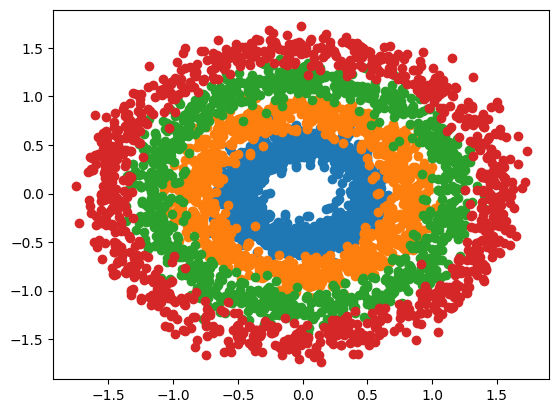

In [70]:
num_circles = 4
spacing = 0.25

circles = [torch.tensor([gen_point(r) for _ in range(num_points)]) for r in torch.linspace(0.5, 1.5, num_circles)]

for circle in circles:
    plt.scatter(circle[:, 0], circle[:, 1])
plt.show()

We can see that there are some interesting points. Some reds bleed into the green, greens into orange, and so on. It might be difficult for the model to get 100% accuracy because of these outliers but let's see how it will do.

Let's again first set up our training data.

In [71]:
data = torch.cat(circles)
labels = torch.cat([torch.full((num_points,), i) for i in range(num_circles)])

idx = torch.randperm(data.size(0))
train = data[idx]
labels = labels[idx]

train_data = train[:int(0.7 * train.size(0))]
train_labels = labels[:int(0.7 * labels.size(0))]
test_data = train[int(0.7 * train.size(0)):]
test_labels = labels[int(0.7 * labels.size(0)):]

print(train_data.size(), train_labels.size())
print(test_data.size(), test_labels.size())

torch.Size([2800, 2]) torch.Size([2800])
torch.Size([1200, 2]) torch.Size([1200])


Now let's create and train our model. It'll be pretty similar to before, but instead of 1 output that's passed through a sigmoid, we'll have 4 outputs, one for each class.

Epoch 0:
	Loss: 1.3976958990097046
	Accuracy: 0.2816666666666667
Epoch 100:
	Loss: 0.863700270652771
	Accuracy: 0.7066666666666667
Epoch 200:
	Loss: 0.6039296388626099
	Accuracy: 0.8616666666666667
Epoch 300:
	Loss: 0.4480520486831665
	Accuracy: 0.8958333333333334
Epoch 400:
	Loss: 0.3677739202976227
	Accuracy: 0.8983333333333333
Epoch 500:
	Loss: 0.3217114806175232
	Accuracy: 0.9025
Epoch 600:
	Loss: 0.2914230227470398
	Accuracy: 0.9
Epoch 700:
	Loss: 0.2689491808414459
	Accuracy: 0.8991666666666667
Epoch 800:
	Loss: 0.2553078830242157
	Accuracy: 0.8991666666666667
Epoch 900:
	Loss: 0.2456701397895813
	Accuracy: 0.9058333333333334


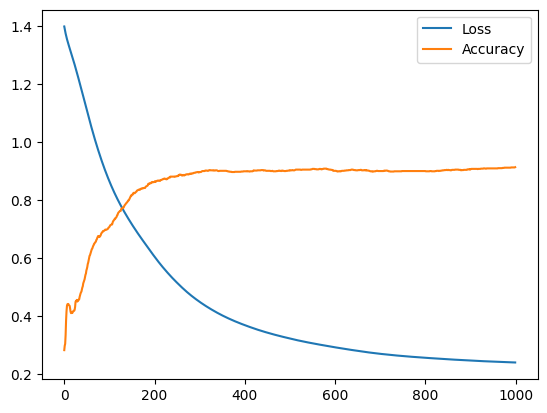

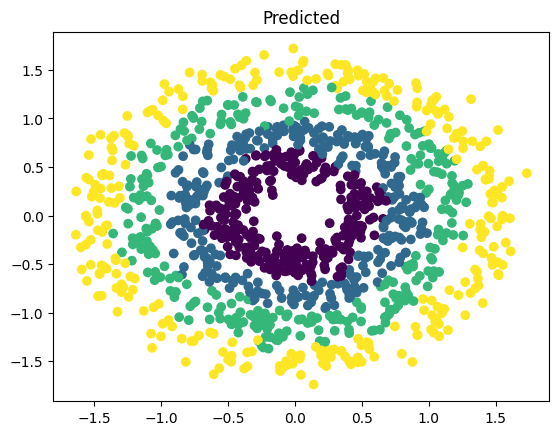

In [72]:
class MultiClassClassification(nn.Module):
    def __init__(self):
        super(MultiClassClassification, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, num_circles),
            # nn.Softmax(dim=1)  # CrossEntropyLoss already applies softmax
        )

    def forward(self, x):
        return self.layers(x)
    
def multi_class_classification(train_x, train_y, test_x, test_y):
    model = MultiClassClassification()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 1000

    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x).squeeze()
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}:\n\tLoss: {loss.item()}')

        with torch.no_grad():
            output = model(test_x).squeeze()
            predicted = torch.argmax(output, dim=1)
            accuracy = (predicted == test_y).sum().item() / test_y.size(0)
            accuracies.append(accuracy)
            if epoch % 100 == 0:
                print(f'\tAccuracy: {accuracy}')

    plt.plot(losses)
    plt.plot(accuracies)
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

    plt.scatter(test_data[:, 0], test_data[:, 1], c=predicted)
    plt.title('Predicted')
    plt.show()

multi_class_classification(train_data, train_labels, test_data, test_labels)

Nice! We predicted the 4 classes pretty well. As mentioned earlier, because of some overlapping in the dataset, we do cap out at about 93% accuracy. This is pretty good and even human raters would have issues classifying these data points.

Besides the change in the model, we also changed the loss function from `BCELoss` (aka BinaryCrossEntropyLoss) to `CrossEntropyLoss`.

For classification problems we usually use some form of Cross Entropy as our loss function. 
- If we have a binary classification with a `Sigmoid`, we use `BCELoss`.
- If we have a multi class classification with a `Softmax`, we use `CrossEntropyLoss`.

One thing to note. We actually don't need to include the Softmax in our model because the `CrossEntropyLoss` will automatically append a `Softmax` when calculating the loss function. Similarly, we can omit the `Sigmoid` for our Binary Classification problem if we replace it with `BCEWithLogitsLoss`.